This is the SVM classifier. It maps out data in a space to then try to draw a line (hyperplane) between the data points to max out the space between the closest data points in each category. The data points closest to the hyperplane in each category have their own lines (support vectors) that defines the margin.

To do this we need to import our libraries. (BEFORE UPLOAD remove unused ones)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCAWe then load the data.

In [52]:
car_data = pd.read_csv('data/ALL_CARS_DATA.csv')

The goal is to classify different types of Chevrolets, so we will extract the all the Chevrolets to its own structure.

In [53]:
chevy = car_data[car_data['BRAND'] == 'Chevrolet']
print('Rows before cleaning', len(chevy))
chevy = chevy.dropna()
print('Rows after cleaning', len(chevy))


Rows before cleaning 26689
Rows after cleaning 26647


The goal with this classifier is to predict the stock type (which in this case is is either "New", "Used" or "Chevrolet Certified"), so we put our predictors in X and the target in Y.

In [54]:
X = chevy[['AGE OF CAR', 'MILEAGE', 'RATING']]
Y = chevy['STOCK TYPE']

We need to scale the numerical features so all features get as much 'room' as needed. If it's not scaled it might cause the data to be very skewed which is something we want to avoid. We encode the target categories as well.

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

l_encoder = LabelEncoder()
Y_encoded = l_encoder.fit_transform(Y)

We split the data into training/test data

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=69)

Now we train the model.

In [57]:
svm_classifier = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=69)
svm_classifier.fit(X_train, Y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


Now we evaluate and see if the model is working well.

In [58]:
Y_pred = svm_classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc}")

report = classification_report(Y_test, Y_pred, target_names=l_encoder.classes_)
print(report)

Accuracy: 0.7953095684803002
                     precision    recall  f1-score   support

Chevrolet Certified       0.11      0.88      0.20       152
                New       0.98      1.00      0.99      2509
               Used       0.99      0.60      0.75      2669

           accuracy                           0.80      5330
          macro avg       0.70      0.82      0.65      5330
       weighted avg       0.96      0.80      0.85      5330



Let's do another run with SMOTE to balance the classes out.

In [59]:
smote = SMOTE(random_state=69)

X_smoted, Y_smoted = smote.fit_resample(X_scaled, Y_encoded)

X_train, X_test, Y_train, Y_test = train_test_split(X_smoted, Y_smoted, test_size=0.2, random_state=69)

svm_classifier = SVC(kernel='rbf', C=1, random_state=69)
svm_classifier.fit(X_train, Y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


We evaluate our new data.

In [60]:
Y_pred = svm_classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc}")

report = classification_report(Y_test, Y_pred, target_names=l_encoder.classes_)
print(report)

Accuracy: 0.8311573076435543
                     precision    recall  f1-score   support

Chevrolet Certified       0.70      0.88      0.78      2616
                New       0.97      1.00      0.99      2686
               Used       0.85      0.61      0.71      2587

           accuracy                           0.83      7889
          macro avg       0.84      0.83      0.83      7889
       weighted avg       0.84      0.83      0.83      7889



Let's visualize our data.

Amount of cars tested in each category:
New                    2686
Chevrolet Certified    2616
Used                   2587
Name: count, dtype: int64


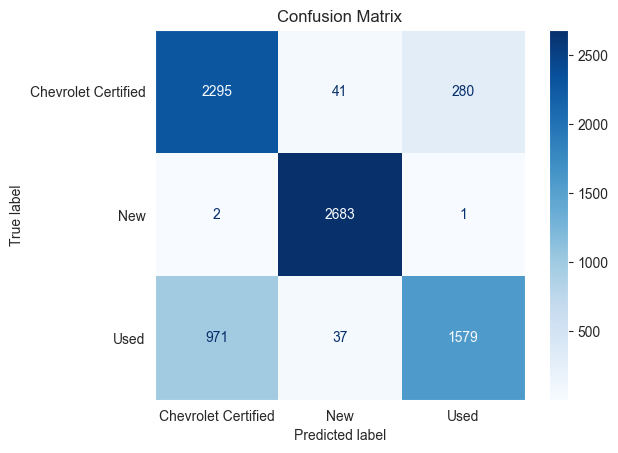

In [66]:
Y_test_str = l_encoder.inverse_transform(Y_test)
Y_pred_str = l_encoder.inverse_transform(Y_pred)

print("Amount of cars tested in each category:")
print(pd.Series(Y_test_str).value_counts())

cm = confusion_matrix(Y_test_str, Y_pred_str, labels=l_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l_encoder.classes_)
disp.plot(cmap='Blues')
disp.ax_.grid(False)

plt.title('Confusion Matrix')
plt.show()

Plot that shows the hyperplanes between each category.

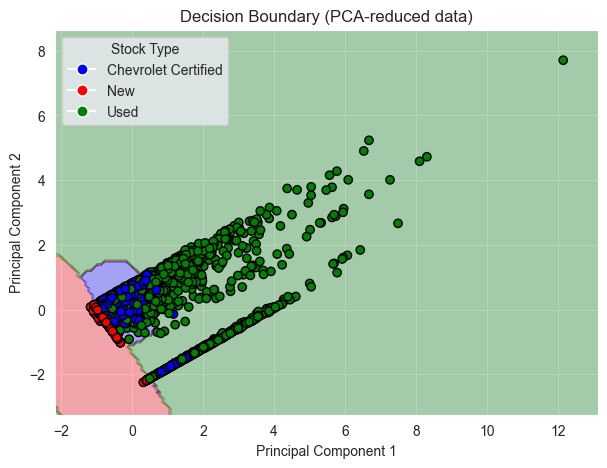

In [62]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_smoted)

X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca, Y_smoted, test_size=0.2, random_state=69)

svm_pca = SVC(kernel='rbf', C=1, random_state=69)
svm_pca.fit(X_train_pca, Y_train_pca)

def plot_decision_boundary(X, y, model, target_names):
    colors = ['blue', 'red', 'green']
    cmap = ListedColormap(colors)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap)

    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=colors[i], markersize=8,
                   label=target_names[i])
        for i in range(len(target_names))
    ]
    plt.legend(handles=handles, title='Stock Type')
    plt.title('Decision Boundary (PCA-reduced data)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_decision_boundary(X_test_pca, Y_test_pca, svm_pca, target_names=l_encoder.classes_)